# Subset concatenated h5ad by tissue

## Imports

In [1]:
orthologous_genes_folder = '/home/olga/googledrive/TabulaMicrocebus/data/orthologous-genes'
# ! ls -lha $orthologous_genes_folder

In [2]:
import os

import anndata
import scanpy as sc
import pandas as pd
import seaborn as sns

from IPython.display import display
sc.settings.verbosity = 3
sc.logging.print_versions()

pd.options.display.max_rows = 200
pd.options.display.max_columns = 50


outdir_gdrive = "/home/olga/googledrive/TabulaMicrocebus/data/cross-species"
outdir_local = "/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species"
outdirs = outdir_gdrive, outdir_local

-----
anndata     0.7.5
scanpy      1.7.0rc1
sinfo       0.3.1
-----
anndata             0.7.5
backcall            0.1.0
cairo               1.18.2
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.0
decorator           4.4.1
get_version         2.1
h5py                2.10.0
igraph              0.7.1
importlib_metadata  0.19
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     0.0.0
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.1.2
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.3
packaging           20.8
pandas              1.1.4
parso               0.5.1
pexpect             4.7.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.2
ptyprocess          0.6.0
pyg

## Load mega-object

In [3]:
%%time

h5ad = os.path.join(
    outdir_local,
    "concatenated__human-lemur-mouse_10x__one2one_orthologs__august2021.h5ad",
)
! ls -lha $h5ad
combined = sc.read(h5ad)

-rw-r--r-- 1 olga czb 5.7G Aug 25 09:18 /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lemur-mouse_10x__one2one_orthologs__august2021.h5ad
CPU times: user 2.13 s, sys: 3.79 s, total: 5.92 s
Wall time: 7.87 s


In [4]:
%%time

sc.pp.calculate_qc_metrics(combined , inplace=True) 

CPU times: user 5min 12s, sys: 9.88 s, total: 5min 22s
Wall time: 20.3 s


/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


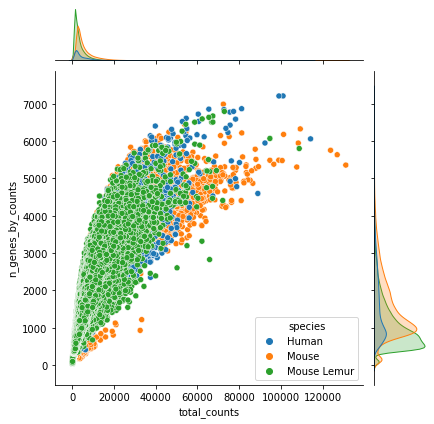

In [5]:
sns.jointplot(
    "total_counts", "n_genes_by_counts", data=combined.obs, hue="species"
)

In [6]:
# sc.pl.dotplot(combined, var_names=['SFTPC'], groupby='narrow_group')

In [7]:
combined.obs.species.value_counts()

Mouse          246288
Mouse Lemur    231752
Human           75041
Name: species, dtype: int64

In [8]:
combined.obs.groupby(['species_batch', 'tissue'], observed=True).size()

species_batch             tissue                
mouse_tabula_muris_senis  Tongue                    20271
                          Heart_and_Aorta            8253
                          Marrow                    39125
                          Mammary_Gland             11954
                          Fat                        6534
                          Kidney                    21038
                          Liver                      7052
                          Lung                      23802
                          Pancreas                   5969
                          Spleen                    34853
                          Thymus                     9082
                          Bladder                    8752
                          Skin                       4308
                          Large_Intestine            1845
                          Trachea                    7901
                          Muscle                    19560
mouse_ce               

# Subset to Lung, Blood, Muscle and write to file

In [9]:
tissues = "Lung", "Blood", "Muscle", "Bladder"
tissues = {
    "lung": ("Lung",),
    "blood": ("Blood",),
    "muscle": ("Muscle", "Limb_Muscle", "Limb_muscle"),
#     "bladder": ("Bladder",),
}


tissue_to_celltype_col = {
    'lung': 'narrow_group',
    'blood': 'narrow_group',
    'muscle': 'narrow_group',
#     'bladder': 'cell_ontology_class'
}

## Assert that all three species are present

In [10]:
assert combined.obs.species.nunique() == 3

## Unify `channel_10x`, `channel`, etc columns

### All data is 10X/10x/droplet method

In [11]:
combined.obs['method'] = '10X'

### Remove sequencing run since not all data has it

In [12]:
combined.obs.drop('sequencing_run', axis=1, errors='ignore', inplace=True) 

### Fill `channel_10x` with `channel` if NA

In [18]:
combined.obs.channel = combined.obs.channel.astype(str)
combined.obs.channel_10x = combined.obs.channel_10x.astype(str)

In [21]:
rows = combined.obs.channel_10x == "nan"
combined.obs.channel_10x.loc[rows] = combined.obs.channel.loc[rows]

obs_cleaned = combined.obs.drop(
    [
        "channel",
        "cell_barcode",
        "mouse.id",
        "louvain",
        "leiden",
        "TMS_muscle_CE_free_annotation",
    ],
    axis=1,
    errors="ignore",
)
obs_cleaned.head()

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,age,cell_id,cell_ontology_class,cell_ontology_id,free_annotation,n_genes,sex,subtissue,tissue,species,species_latin,n_counts,individual,narrow_group,broad_group,compartment_group,cell,method,tissue_free_annotation,TMS_muscle_ADM_free_annotation,TMS_muscle_CE_compartment,batch,compartment,channel_10x,species_batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACCTGCAGTAAGCG-1-0-0-0-0-mouse_tabula_muris_senis,24m,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,3481.0,male,nan,Tongue,Mouse,Mus musculus,1.0,mouse_18_24-M-60,nan,nan,nan,nan,10X,nan,nan,nan,0,nan,MACA_24m_M_TONGUE_60,mouse_tabula_muris_senis,2741,7.916443,16337.0,9.701249,42.149721,58.652139,68.366285,79.249556
AAACCTGTCATTATCC-1-0-0-0-0-mouse_tabula_muris_senis,24m,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,2599.0,male,nan,Tongue,Mouse,Mus musculus,1.0,mouse_18_24-M-60,nan,nan,nan,nan,10X,nan,nan,nan,0,nan,MACA_24m_M_TONGUE_60,mouse_tabula_muris_senis,2062,7.631917,8185.0,9.010180,39.169212,54.697618,64.557117,76.566891
AAACGGGGTACAGTGG-1-0-0-0-0-mouse_tabula_muris_senis,24m,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,3468.0,male,nan,Tongue,Mouse,Mus musculus,1.0,mouse_18_24-M-60,nan,nan,nan,nan,10X,nan,nan,nan,0,nan,MACA_24m_M_TONGUE_60,mouse_tabula_muris_senis,2744,7.917536,15459.0,9.646011,38.560062,54.421373,65.211204,77.430623
AAACGGGGTCTTCTCG-1-0-0-0-0-mouse_tabula_muris_senis,24m,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,3189.0,male,nan,Tongue,Mouse,Mus musculus,1.0,mouse_18_24-M-60,nan,nan,nan,nan,10X,nan,nan,nan,0,nan,MACA_24m_M_TONGUE_60,mouse_tabula_muris_senis,2546,7.842671,10061.0,9.216521,40.483053,53.533446,61.733426,73.561276
AAAGATGAGCTATGCT-1-0-0-0-0-mouse_tabula_muris_senis,24m,MACA_24m_M_TONGUE_60_AAAGATGAGCTATGCT,keratinocyte,NA,suprabasal,3419.0,male,nan,Tongue,Mouse,Mus musculus,1.0,mouse_18_24-M-60,nan,nan,nan,nan,10X,nan,nan,nan,0,nan,MACA_24m_M_TONGUE_60,mouse_tabula_muris_senis,2702,7.902118,15226.0,9.630825,39.839748,55.727046,65.926704,77.321687


## Set `.obs` as new `obs_cleaned`

In [23]:
combined.obs = obs_cleaned

## Subset and remove unused categories

In [26]:
def remove_unused_obs_categories(adata):
    """Remove all unused cell ontology class, free annotations, ages, etc using pandas"""
    for col_name, col_series in adata.obs.items():
        try:
            adata.obs[col_name] = col_series.cat.remove_unused_categories()
        except AttributeError:
            continue
    return adata


for tissue_key, tissue_names in tissues.items():
    print(f"--- {tissue_key} ---")
    combined_tissue = combined[combined.obs.tissue.isin(tissue_names)]

    # Remove all unused cell ontology class, free annotations, ages, etc
    combined_tissue = remove_unused_obs_categories(combined_tissue)
    combined_tissue.obs['tissue'] = tissue_key.capitalize()

    if tissue_key == "lung":
        # Remove Sapiens for lung
        combined_tissue = combined_tissue[
            combined_tissue.obs.species_batch != "human_sapiens"
        ]

    celltype_col = tissue_to_celltype_col[tissue_key]

    display(
        combined_tissue.obs.groupby(
            ["compartment_group", "broad_group", "narrow_group", "species"],
            observed=True,
        )
        .size()
        .unstack()
        .fillna(0).astype(int)
    )
    display(
        combined_tissue.obs.groupby(
            ["compartment_group", "broad_group", "narrow_group", "species_batch"],
            observed=True,
        )
        .size()
        .unstack()
        .fillna(0).astype(int)
    )
    #     print(combined_tissue.obs.groupby([celltype_col, 'species_batch'], observed=True).size())
    #     print(combined_tissue.obs.groupby([celltype_col, 'species'], observed=True).size())

    display(
        combined_tissue.obs.groupby(
            ["tissue", "species", "channel_10x", "method"]
        )
        .size()
        .to_frame()
    )
    
    print(combined_tissue)
    for d in outdirs:
        h5ad = os.path.join(
            d,
            f"concatenated__human-lemur-mouse_10x__one2one_orthologs__{tissue_key}__august2021.h5ad",
        )

        print(h5ad)
        %time combined_tissue.write(h5ad)

Trying to set attribute `.obs` of view, copying.


--- lung ---


species                                                                                                Mouse  \
compartment_group       broad_group                            narrow_group                                    
lymphoid                B cell                                 B cell                                   1457   
                        natural killer cell                    natural killer cell                      1141   
                        T cell                                 T cell (CD8+)                             854   
                                                               T cell (LY6G5B+)                          154   
                                                               T cell (CD4+)                             534   
                                                               Regulatory T cell                         121   
                        natural killer T cell                  natural killer T cell                     406   
                        natural killer cell_T cell (PF)        natural killer cell_T cell (PF)           117   
                        plasma cell                            plasma cell                                47   
                        natural killer cell_T cell             natural killer cell_T cell                  0   
                        innate lymphoid cell                   innate lymphoid cell                        0   
myeloid                 monocyte                               monocyte                                 7926   
                                                               monocyte (PF)                            2393   
                                                               proliferating monocyte                      0   
                        macrophage                             alveolar macrophage                      1217   
                                                               alveolar macrophage (PF)                  102   
                                                               interstitial macrophage                  1115   
                        dendritic cell                         conventional dendritic cell               241   
                                                               dendritic cell (PF)                        25   
                                                               plasmacytoid dendritic cell                73   
                                                               dendritic cell (CCR7+ )                    15   
                                                               dendritic cell (IGSF21+)                    0   
                                                               dendritic cell (EREG+)                      0   
                                                               dendritic cell (TREM2+)                     0   
                                                               dendritic cell (FLT3+ IGSF6+)               0   
                                                               mature dendritic cell                       0   
                        neutrophil                             neutrophil                                543   
                                                               proliferating neutrophil                    0   
                        basophil                               basophil                                  128   
                        eosinophil                             eosinophil                                  0   
                        granulocyte monocyte progenitor cell   granulocyte monocyte progenitor cell        0   
endothelial             capillary cell                         capillary cell                           1743   
                                                               capillary aerocyte cell                   512   
                                                               capillary interme

species_batch                                                                                          mouse_tabula_muris_senis  \
compartment_group       broad_group                            narrow_group                                                       
lymphoid                B cell                                 B cell                                                      1457   
                        natural killer cell                    natural killer cell                                         1141   
                        T cell                                 T cell (CD8+)                                                854   
                                                               T cell (LY6G5B+)                                             154   
                                                               T cell (CD4+)                                                534   
                                                               Regulatory T cell                                            121   
                        natural killer T cell                  natural killer T cell                                        406   
                        natural killer cell_T cell (PF)        natural killer cell_T cell (PF)                              117   
                        plasma cell                            plasma cell                                                   47   
                        natural killer cell_T cell             natural killer cell_T cell                                     0   
                        innate lymphoid cell                   innate lymphoid cell                                           0   
myeloid                 monocyte                               monocyte                                                    7926   
                                                               monocyte (PF)                                               2393   
                                                               proliferating monocyte                                         0   
                        macrophage                             alveolar macrophage                                         1217   
                                                               alveolar macrophage (PF)                                     102   
                                                               interstitial macrophage                                     1115   
                        dendritic cell                         conventional dendritic cell                                  241   
                                                               dendritic cell (PF)                                           25   
                                                               plasmacytoid dendritic cell                                   73   
                                                               dendritic cell (CCR7+ )                                       15   
                                                               dendritic cell (IGSF21+)                                       0   
                                                               dendritic cell (EREG+)                                         0   
                                                               dendritic cell (TREM2+)                                        0   
                                                               dendritic cell (FLT3+ IGSF6+)                                  0   
                                                               mature dendritic cell                                          0   
                        neutrophil                             neutrophil                                                   543   
                                                               proliferating neutrophil                                       0   
                        basophil                               basophi

0
tissue species     channel_10x        method      
Lung   Human       10X_P1_14          10X        0
                   10X_P1_6           10X        0
                   10X_P2_5           10X        0
                   10X_P3_0           10X        0
                   10X_P5_13          10X        0
                   10X_P5_14          10X        0
                   10X_P7_8           10X        0
                   10X_P7_9           10X        0
                   10X_P8_12          10X        0
                   10X_P8_13          10X        0
                   L1_Lung_10X        10X        0
                   L2_Lung_10X        10X        0
                   L3_Lung_10X        10X        0
                   L4_Lung_P1_10X     10X        0
                   L4_Lung_P2_10X     10X        0
                   L4_Lung_P3_10X     10X        0
                   MACA_18m_F_LUNG_50 10X        0
                   MACA_18m_F_LUNG_51 10X        0
                   MACA_18m_M_LUNG_52 10X        0
                   MACA_18m_M_LUNG_53 10X        0
                   MACA_21m_F_LUNG_54 10X        0
                   MACA_21m_F_LUNG_55 10X        0
                   P1_2               10X     2148
                   P1_3               10X     2407
                   P1_4               10X     2826
                   P2_1               10X     4039
                   P2_2               10X     3391
                   P2_3               10X     2829
                   P2_4               10X     1332
                   P2_5               10X     5803
                   P2_6               10X     1381
                   P2_7               10X     4055
                   P2_8               10X     4064
                   P3_2               10X     1925
                   P3_3               10X     3880
                   P3_4               10X     1457
                   P3_5               10X     4325
                   P3_6               10X     5237
                   P3_7               10X     6254
       Mouse       10X_P1_14          10X     1565
                   10X_P1_6           10X     7728
                   10X_P2_5           10X      920
                   10X_P3_0           10X      496
                   10X_P5_13          10X     1043
                   10X_P5_14          10X     1384
                   10X_P7_8           10X      348
                   10X_P7_9           10X      979
                   10X_P8_12          10X      578
                   10X_P8_13          10X     1636
                   L1_Lung_10X        10X        0
                   L2_Lung_10X        10X        0
                   L3_Lung_10X        10X        0
                   L4_Lung_P1_10X     10X        0
                   L4_Lung_P2_10X     10X        0
                   L4_Lung_P3_10X     10X        0
                   MACA_18m_F_LUNG_50 10X      320
                   MACA_18m_F_LUNG_51 10X     1138
                   MACA_18m_M_LUNG_52 10X     1573
                   MACA_18m_M_LUNG_53 10X     1256
                   MACA_21m_F_LUNG_54 10X     1312
                   MACA_21m_F_LUNG_55 10X     1526
                   P1_2               10X        0
                   P1_3               10X        0
                   P1_4               10X        0
                   P2_1               10X        0
                   P2_2               10X        0
                   P2_3               10X        0
                   P2_4               10X        0
                   P2_5               10X        0
                   P2_6               10X        0
                   P2_7               10X        0
                   P2_8               10X        0
                   P3_2               10X        0
                   P3_3               10X        0
                   P3_4               10X        0
                   P3_5               10X        0
                   P3_6               10X        0
                   P

/home/olga/miniconda3/envs/tabula-microcebus-jan2021/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 114218 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'n_genes', 'sex', 'subtissue', 'tissue', 'species', 'species_latin', 'n_counts', 'individual', 'narrow_group', 'broad_group', 'compartment_group', 'cell', 'method', 'tissue_free_annotation', 'TMS_muscle_ADM_free_annotation', 'TMS_muscle_CE_compartment', 'batch', 'compartment', 'channel_10x', 'species_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'mouse_lemur__gene_name', 'mouse__gene_name', 'name-lemur', 'highly_variable-lemur', 'n_cells-mouse_tabula_muris_senis', 'means-1-mouse_tabula_muris_senis', 'dispersions-1-mouse_tabula_muris_senis', 'dispersions_norm-1-mouse_tabula_muris_senis', 'highly_variable-1-mouse_tabula_muris_senis', 'n_cells_by_counts', 'mean_count

... storing 'tissue' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'channel_10x' as categorical


CPU times: user 2.12 s, sys: 2.05 s, total: 4.17 s
Wall time: 56.6 s
/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lemur-mouse_10x__one2one_orthologs__lung__august2021.h5ad


Trying to set attribute `.obs` of view, copying.


CPU times: user 674 ms, sys: 1.02 s, total: 1.7 s
Wall time: 2.72 s
--- blood ---


species                                                                                                    Mouse  \
compartment_group       broad_group                              narrow_group                                      
lymphoid                natural killer cell                      natural killer cell                         540   
                        B cell                                   B cell                                     1876   
                        T cell                                   T cell (CD8+)                               477   
                                                                 T cell (CD4+)                               578   
                                                                 T cell (TMEM176+)                             9   
                                                                 T cell (CXCR6+)                              19   
                        proliferating natural killer cell_T cell proliferating natural killer cell_T cell     37   
                        proliferating B cell_T cell              proliferating B cell_T cell                  16   
                        plasma cell                              plasma cell                                   0   
                        natural killer T cell                    natural killer T cell                         0   
myeloid                 monocyte                                 monocyte                                   1460   
                                                                 proliferating monocyte                        0   
                        neutrophil                               neutrophil                                 2685   
                                                                 proliferating neutrophil                      0   
                        dendritic cell                           conventional dendritic cell                  39   
                                                                 plasmacytoid dendritic cell                  38   
                                                                 dendritic cell                               20   
                                                                 IGSF21+ dendritic cell                        0   
                        macrophage                               macrophage                                  340   
                        basophil                                 basophil                                     66   
nan                     nan                                      nan                                        6452   
                        doublet                                  doublet                                    1315   
megakaryocyte-erythroid platelet                                 platelet                                     17   
                                                                 megakaryocyte progenitor cell                 0   
                        erythroid lineage cell                   erythroid lineage cell                        5   
                                                                 proliferating erythroid lineage cell          0   
                                                                 erythroid progenitor cell                     0   
stromal                 mesothelial cell                         mesothelial cell                              0   
hematopoietic           hematopoietic precursor cell             hematopoietic precursor cell                  0   
endothelial             capillary cell                           capillary cell                                0   

species                                                                                                    Human  \
compartment_group       broad_group                              narrow_group                                      
lymphoid                natural killer cell            

species_batch                                                                                              mouse_ce  \
compartment_group       broad_group                              narrow_group                                         
lymphoid                natural killer cell                      natural killer cell                            540   
                        B cell                                   B cell                                        1876   
                        T cell                                   T cell (CD8+)                                  477   
                                                                 T cell (CD4+)                                  578   
                                                                 T cell (TMEM176+)                                9   
                                                                 T cell (CXCR6+)                                 19   
                        proliferating natural killer cell_T cell proliferating natural killer cell_T cell        37   
                        proliferating B cell_T cell              proliferating B cell_T cell                     16   
                        plasma cell                              plasma cell                                      0   
                        natural killer T cell                    natural killer T cell                            0   
myeloid                 monocyte                                 monocyte                                      1460   
                                                                 proliferating monocyte                           0   
                        neutrophil                               neutrophil                                    2685   
                                                                 proliferating neutrophil                         0   
                        dendritic cell                           conventional dendritic cell                     39   
                                                                 plasmacytoid dendritic cell                     38   
                                                                 dendritic cell                                  20   
                                                                 IGSF21+ dendritic cell                           0   
                        macrophage                               macrophage                                     340   
                        basophil                                 basophil                                        66   
nan                     nan                                      nan                                           6452   
                        doublet                                  doublet                                       1315   
megakaryocyte-erythroid platelet                                 platelet                                        17   
                                                                 megakaryocyte progenitor cell                    0   
                        erythroid lineage cell                   erythroid lineage cell                           5   
                                                                 proliferating erythroid lineage cell             0   
                                                                 erythroid progenitor cell                        0   
stromal                 mesothelial cell                         mesothelial cell                                 0   
hematopoietic           hematopoietic precursor cell             hematopoietic precursor cell                     0   
endothelial             capillary cell                           capillary cell                                   0   

species_batch                                                                                              human_hlca  \
compartment_group       broad_group                              narro

0
tissue species     channel_10x       method       
Blood  Human       L1_Blood_10X      10X         0
                   L2_Blood_10X      10X         0
                   L3_Blood_10X      10X         0
                   L4_Blood_10X      10X         0
                   Mouse_Blood_1_10X 10X         0
                   Mouse_Blood_2_10X 10X         0
                   P1_1              10X      2173
                   P3_8              10X      2300
       Mouse       L1_Blood_10X      10X         0
                   L2_Blood_10X      10X         0
                   L3_Blood_10X      10X         0
                   L4_Blood_10X      10X         0
                   Mouse_Blood_1_10X 10X      5493
                   Mouse_Blood_2_10X 10X     10496
                   P1_1              10X         0
                   P3_8              10X         0
       Mouse Lemur L1_Blood_10X      10X     12860
                   L2_Blood_10X      10X      4999
                   L3_Blood_10X      10X      3405
                   L4_Blood_10X      10X       212
                   Mouse_Blood_1_10X 10X         0
                   Mouse_Blood_2_10X 10X         0
                   P1_1              10X         0
                   P3_8              10X         0

... storing 'tissue' as categorical
... storing 'method' as categorical
... storing 'channel_10x' as categorical


AnnData object with n_obs × n_vars = 41938 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'n_genes', 'sex', 'subtissue', 'tissue', 'species', 'species_latin', 'n_counts', 'individual', 'narrow_group', 'broad_group', 'compartment_group', 'cell', 'method', 'tissue_free_annotation', 'TMS_muscle_ADM_free_annotation', 'TMS_muscle_CE_compartment', 'batch', 'compartment', 'channel_10x', 'species_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'mouse_lemur__gene_name', 'mouse__gene_name', 'name-lemur', 'highly_variable-lemur', 'n_cells-mouse_tabula_muris_senis', 'means-1-mouse_tabula_muris_senis', 'dispersions-1-mouse_tabula_muris_senis', 'dispersions_norm-1-mouse_tabula_muris_senis', 'highly_variable-1-mouse_tabula_muris_senis', 'n_cells_by_counts', 'mean_counts', 'log1

Trying to set attribute `.obs` of view, copying.


CPU times: user 410 ms, sys: 205 ms, total: 615 ms
Wall time: 848 ms
--- muscle ---


species                                                                                                                        Mouse  \
compartment_group       broad_group                                        narrow_group                                                
myeloid                 monocyte                                           classical monocyte                                    254   
                                                                           non-classical monocyte                                 50   
                        unknown_myeloid (CD209A+)                          unknown_myeloid (CD209A+)                             227   
                        macrophage                                         macrophage                                            793   
                        conventional dendritic cell                        conventional dendritic cell                           107   
                                                                           conventional dendritic cell (PF)                       15   
                        neutrophil                                         neutrophil                                            106   
                                                                           neutrophil (PF)                                        27   
                        neutrophil_monocyte                                neutrophil_monocyte                                    14   
                        plasmacytoid dendritic cell                        plasmacytoid dendritic cell                            10   
                        dendritic cell                                     mature dendritic cell                                  26   
                        basophil                                           basophil                                                6   
                        unknown_myeloid (PF CD209A+)                       unknown_myeloid (PF CD209A+)                           16   
endothelial             capillary cell                                     capillary cell                                       2499   
                                                                           capillary cell (CXCL10+)                                0   
                        unknown_endothelial (COL13A1+)                     unknown_endothelial (COL13A1+)                         50   
                        vein cell                                          vein cell                                             777   
                                                                           vein cell (PF)                                          0   
                        artery cell_capillary cell (RBP7+)                 artery cell_capillary cell (RBP7+)                    286   
                        artery cell                                        artery cell                                           763   
                        lymphatic cell                                     lymphatic cell                                        265   
stromal                 tendon cell                                        tendon cell                                          1944   
                        fibroadipogenic progenitor cell                    fibroadipogenic progenitor cell                      6483   
                        unknown_stromal (CLDN1+)                           unknown_stromal (CLDN1+)                              152   
                        skeletal muscle satellite stem cell                skeletal muscle satellite stem cell                  1176   
                                                                           skeletal muscle satellite stem cell (MYOG+)            10   
                                                                           skeletal muscle satellite stem cell (PF)                0   
                        fast muscle cell                

species_batch                                                                                                                  mouse_tabula_muris_senis  \
compartment_group       broad_group                                        narrow_group                                                                   
myeloid                 monocyte                                           classical monocyte                                                       254   
                                                                           non-classical monocyte                                                    50   
                        unknown_myeloid (CD209A+)                          unknown_myeloid (CD209A+)                                                227   
                        macrophage                                         macrophage                                                               793   
                        conventional dendritic cell                        conventional dendritic cell                                              107   
                                                                           conventional dendritic cell (PF)                                          15   
                        neutrophil                                         neutrophil                                                               106   
                                                                           neutrophil (PF)                                                           27   
                        neutrophil_monocyte                                neutrophil_monocyte                                                       14   
                        plasmacytoid dendritic cell                        plasmacytoid dendritic cell                                               10   
                        dendritic cell                                     mature dendritic cell                                                     26   
                        basophil                                           basophil                                                                   6   
                        unknown_myeloid (PF CD209A+)                       unknown_myeloid (PF CD209A+)                                              16   
endothelial             capillary cell                                     capillary cell                                                          2499   
                                                                           capillary cell (CXCL10+)                                                   0   
                        unknown_endothelial (COL13A1+)                     unknown_endothelial (COL13A1+)                                            50   
                        vein cell                                          vein cell                                                                777   
                                                                           vein cell (PF)                                                             0   
                        artery cell_capillary cell (RBP7+)                 artery cell_capillary cell (RBP7+)                                       286   
                        artery cell                                        artery cell                                                              763   
                        lymphatic cell                                     lymphatic cell                                                           265   
stromal                 tendon cell                                        tendon cell                                                             1944   
                        fibroadipogenic progenitor cell                    fibroadipogenic progenitor cell                                         6483   
                        unknown_stromal (CLDN1+)                           unknown_stromal (CLDN1+)                          

0
tissue species     channel_10x        method       
Muscle Human       L2_Limb_muscle_10X 10X         0
                   nan                10X     13215
       Mouse       L2_Limb_muscle_10X 10X         0
                   nan                10X     19560
       Mouse Lemur L2_Limb_muscle_10X 10X      3125
                   nan                10X         0

... storing 'tissue' as categorical
... storing 'method' as categorical
... storing 'channel_10x' as categorical


AnnData object with n_obs × n_vars = 35900 × 13302
    obs: 'age', 'cell_id', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'n_genes', 'sex', 'subtissue', 'tissue', 'species', 'species_latin', 'n_counts', 'individual', 'narrow_group', 'broad_group', 'compartment_group', 'cell', 'method', 'tissue_free_annotation', 'TMS_muscle_ADM_free_annotation', 'TMS_muscle_CE_compartment', 'batch', 'compartment', 'channel_10x', 'species_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'mouse_lemur__gene_name', 'mouse__gene_name', 'name-lemur', 'highly_variable-lemur', 'n_cells-mouse_tabula_muris_senis', 'means-1-mouse_tabula_muris_senis', 'dispersions-1-mouse_tabula_muris_senis', 'dispersions_norm-1-mouse_tabula_muris_senis', 'highly_variable-1-mouse_tabula_muris_senis', 'n_cells_by_counts', 'mean_counts', 'log1

In [ ]:
ll /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated*july2021.h5ad

In [ ]:
ll /home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated*august2021.h5ad

In [ ]:
combined_tissue[-5:, :10].to_df()

In [ ]:
combined_tissue.obs.head()

In [ ]:
combined_tissue.obs.groupby(['tissue', 'species', 'channel', 'channel_10x', 'sequencing_run', 'method']).size()

In [ ]:
combined.obs.groupby(['tissue', 'species', 'channel', 'channel_10x', 'sequencing_run', 'method']).size()

In [ ]:
1+1